# INF367A
# Implementation of Paper

&nbsp;

### Paper:
    
*SatSynth: Augmenting Image-Mask Pairs through Diffusion Models for Aerial Semantic Segmentation*

&nbsp;

### Description:
In the following notebook I will be implementing the novel method explained in the SatSynth paper. This implementation will furthermore be used for downstream segmentation in our [identifying deforestation drivers](https://solafune.com/competitions/68ad4759-4686-4bb3-94b8-7063f755b43d?menu=about&tab=overview) competition. The method is utilizing a Denoising Diffusion Probabilistic Model (DDPM) to generate a synthetic dataset w. labels denoted $\mathcal{D'}$. The union $\mathcal{D} \cup \mathcal{D'}$ is then utilized.


&nbsp;

<p style="font-size:15px;text-align:right;"><b>Created by: </b>Tobias Husebø</p>

&nbsp;

&nbsp;

------

&nbsp;

#### Imports:

> **Description**: In the following section I will import the necessary packages for completing the implementation of SatSynth as explained in the paper.

In [1]:
## Machine Learning Libraries: 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import segmentation_models_pytorch as smp
from torchmetrics import F1Score 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.ops import box_convert
from torchvision.transforms.functional import convert_image_dtype, to_pil_image
from torchvision.utils import draw_bounding_boxes, save_image
from torch.nn import CrossEntropyLoss
from torch.profiler import profile, record_function, ProfilerActivity


## Math imports:
import numpy as np
import matplotlib.pyplot as plt
import math 
import random


## Plotting / Image processing imports:
import json
import os
import re
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle
import rasterio
from rasterio.plot import show
from tqdm import tqdm

&nbsp; 

-----

&nbsp;

#### Initialization:

> **Description**: In the following section I will set manual seed and main computing unit.

In [2]:
# Initializing seed, datatype and main computing unit:
torch.manual_seed(72)
torch.set_default_dtype(torch.float32)

device = torch.device("cpu")
data_path = "../data"

&nbsp; 

-----

&nbsp;

#### Loading Images and labels & defining a pytorch dataset class:

> **Description**: In the following section I will define a `SatelliteImgDataset` class following the pytorch dataset module, and a `retrieve_images_and_labels()` which retrieves images and labels. This will be used for further streamlining of the diffusion of the joint pair of images and labels. In the `__getitem__()` function in the dataset class we normalize the values and cast the labels via log encoding such that the images go from $x_i\in\mathbb{R}^{3 \times H \times W}, y_i \in \{0,1,\ldots,K-1\}^{H \times W} \rightarrow (x_i, y_i)\in[0, 1]^{H\times W \times (C + [\log_2 K])}$. Right before sending it to the model we switch the scale from $[0,1] \rightarrow [-1, 1]$ for numerical stability.
>
> Also, in the paper they are training a model to diffuse images where $img\in\mathbb{R}^{C\times 128 \times 128}$ resolution pictures and upsample to $img\in\mathbb{R}^{C\times 2\cdot 128 \times 2\cdot 128}$. This is way to small for my dataset as each image has a resolution equal to $img\in\mathbb{R}^{C\times 1024 \times 1024}$. Therefore, I propose to make a new dataset class `FixedGridCropDataset` which wraps the `SatelliteImgDataset` and returns images of size $img\in\mathbb{R}^{C\times 256 \times 256}$ from fixed crops of the original image. Thus, we can later on define a tiling method to tile the diffused pictures back together.

&nbsp;

**Function for loading image and labels:**

In [3]:
class SatelliteImgDataset(Dataset):
    '''
    Class defining a PyTorch Dataset for streamlining the training
    of the diffusion model.

    Attributes:
    - paths (List[Str]): List of file paths to the satellite images.
    - labels_dict (Dict): Dictionary holding the labels (annotations) for each image.
    - feature_map (Dict): Dictionary mapping class names to integer indices for segmentation masks.
    - num_classes (Int): The number of unique classes in the dataset.
    - sanity_check (Bool): Whether or not to run in sanity check mode.
        
    Functions:
    - __len__(): Returns the number of images.
    - __getitem__(): Loads and returns an image with its segmentation masks.
    - _normalize_per_band(): Private function for normalizing each band wrt. percentile given
    - _read_image(): Private function for reading an image from a given path using rasterio.
    
    '''
    def __init__(self, paths, labels_dict, feature_map, sanity_check=False):
        self.paths = paths
        self.labels_dict = labels_dict
        self.feature_map = feature_map
        self.num_classes = len(feature_map)
        self.sanity_check = sanity_check
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, idx):
        # Current image tensor:
        path = self.paths[idx]
        img = self._read_image(path)
    
        # Initialize label_map of shape (H, W)
        H, W = img.shape[1], img.shape[2]
        label_map = torch.zeros((H, W), dtype=torch.int32)
    
        # Access the segmentations of the current image:
        labels = self.labels_dict["train_" + str(extract_number(os.path.basename(path))) + ".tif"]
    
        # For each unique annotation:
        for annotation in labels['annotations']:
    
            # Retrieve segmentation and "band index"
            curr_seg = annotation['segmentation']
            curr_seg_class_idx = self.feature_map[annotation['class']]
                
            # Reshape to correct cv2.fillPoly format and create mask
            polygon = np.array(curr_seg, dtype=np.int32).reshape(-1, 1, 2)
            mask = np.zeros((H, W), dtype=np.int32)
            cv2.fillPoly(mask, [polygon], 1)

            
            # Write to label map before log_2 binary encoding
            t_mask = torch.from_numpy(mask).bool()
            label_map[t_mask] = curr_seg_class_idx

        # Bit-space encoding:
        ##################################################
        #     Help from ChatGPT for bitspace encoding    #
        ##################################################
        B = int(np.ceil(np.log2(self.num_classes)))
        extra_bit_bands = torch.zeros((B, H, W), dtype=torch.int32)

        # For each bit, append apporpriate binary value to bit-space bands
        for b in range(B):
            bit_mask = (label_map >> b) & 1
            extra_bit_bands[b] = bit_mask.to(torch.int32)
            
        # Concatenate to fully functional tensor
        if self.sanity_check:
            full_tensor = torch.cat([img, extra_bit_bands.float(), label_map.unsqueeze(0).float()], dim=0)
        else:
            full_tensor = torch.cat([img, extra_bit_bands], dim=0)
            
            # Last step as mentioned in paper, Scale from [0, 1] to [-1, 1] to increase
            # numerical stability
            full_tensor = 2*full_tensor-1
        
        return full_tensor.float()

    def _normalize_per_band(self, img, lower_percentile=0, upper_percentile=98):
        '''Normalize each band with regards its current upper_percentile and cast to [0, 1]'''
        ##########################################################
        #  little Help from ChatGPT for percentile normalization #
        #  percentile normalization.                             #
        ##########################################################
        out = []
        for c in range(img.shape[0]):
            band = img[c]
            p = np.percentile(band, upper_percentile)
            p = max(p, 1.0)  # prevent divide-by-zero
            band = band / p
            band = np.clip(band, 0, 1)
            out.append(torch.from_numpy(band))
        return torch.stack(out, dim=0)

    def _read_image(self, curr_img_path):
        '''Open a specific tif image with rasterio and return array'''
        ######################################################
        #    little Help from ChatGPT for NaN handling       #
        ######################################################
        with rasterio.open(curr_img_path) as src_file:
            # Only return RGB bands (4: Red, 3: Green, 2: Blue)
            img_masked = src_file.read([4, 3, 2], masked=True)
            img_filled = img_masked.filled(0)

            # In case of any remaining NaN/Inf, force them out
            img_clean = np.nan_to_num(img_filled, nan=0.0,
                                      posinf=0.0, neginf=0.0)

            # Normalize each band
            img_clean = self._normalize_per_band(img_clean)
            
            return img_clean



class FixedGridCropDataset(Dataset):
    '''
    Class defining a pytorch dataset, functioning as a wrapper on top of the
    already implemented SatelliteImgDataset. Works by returning patches of the
    original dataset.
    
    Attributes:
    - base_dataset (Dataset): Dataset returning 1024×1024 tensors in __getitem__.
    - patch_size (Int): size of each non-overlapping crop

    Functions:
    - __len__(): Returns the number of images.
    - __getitem__(): Loads and returns an image with its segmentation masks.
    '''
    def __init__(self, base_dataset, patch_size=256):
    #################################################################
    #  little help from ChatGPT for understanding dataset wrappers  #
    #################################################################
        # Initialize values
        self.base = base_dataset
        self.P = patch_size
        self.H, self.W = 1024, 1024

        # Compute how many crops along each axis
        crops_x_axis = self.W // self.P  
        crops_y_axis = self.H // self.P

        # build (img_idx, y0, x0) for every tile
        self.coords = []
        for img_idx in range(len(self.base)):
            for row in range(crops_y_axis):
                for col in range(crops_x_axis):
                    y0 = row * self.P
                    x0 = col * self.P
                    self.coords.append((img_idx, y0, x0))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img = self.base[self.coords[idx][0]]
        y0, x0 = self.coords[idx][1], self.coords[idx][2]
        patch = img[:, y0:y0+self.P, x0:x0+self.P] 
        return patch
        




# Main function for retrieving images and labels
def retrieve_images_and_labels():
    '''Retrieves file paths and dictionary holding labels'''
    img_file_paths = retrieve_sorted_filepaths_img() # Retrieve paths to images
    labels_dict = load_json_annotations()            # Retrieve label dictionary
    feature_map = find_classes(labels_dict)          # Retrieve feature map
    
    return img_file_paths, labels_dict, feature_map





# Helper functions
def find_classes(labels_dict):
    '''Create feature map of all features'''
    feature_map = {}
    feature_map['background'] = 0 # Include background!
    for image in labels_dict.values():
        for annotation in image.get('annotations'):
            class_name = annotation['class']
            if class_name not in feature_map:
                feature_map[class_name] = len(feature_map)
    return feature_map
        
def load_json_annotations():
    '''Load JSON file with annotations'''
    curr_dir = os.getcwd()
    curr_file = os.path.join(curr_dir, "data", "train_annotations.json")
    with open(curr_file, 'r') as file:
        data = json.load(file)
        return {img['file_name']: img for img in data['images']}

def retrieve_sorted_filepaths_img():
    '''Function for retrieving images in a sorted manner'''
    curr_dir = os.getcwd()
    curr_dir = os.path.join(curr_dir, "data", "train_images")
    file_paths = sorted([os.path.join(curr_dir, f) for f in os.listdir(curr_dir) if os.path.isfile(os.path.join(curr_dir, f))],
                         key=lambda x: extract_number(os.path.basename(x)))
    return file_paths

def extract_number(f):
    '''Function for extracting number in filename'''
    match = re.search(r'\d+', f)  # Extract first number found in filename
    return int(match.group())

&nbsp;

**Quick sanity check to see that it is working:**

In [4]:
# Prepare for sanity check:
paths, labels, fmap = retrieve_images_and_labels()
dataset = SatelliteImgDataset(paths, labels, fmap, sanity_check=True)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
batch = next(iter(loader))

# Retrieve first image
image_1 = batch[0]

# shape: (3 + B + 1 (label_map), H, W)
C, H, W = image_1.shape

# number of bit-planes
B = C - 4   # 3 RGB channels + B bits + 1 label_map

# split out the bit-planes and the stored “true” map
bits      = image_1[3:3+B]                # shape (B, H, W)
label_map = image_1[3+B].to(torch.int32)  # shape (H, W)

# threshold to recover exact 0/1 bits
bits_int = (bits > 0.5).to(torch.int32)

# reconstruct via bit-shifts
label_map_recon = torch.zeros((H, W), dtype=torch.int32, device=bits.device)

print(f"Label map recon shape: {label_map_recon.shape}")
print(f"Label map shape: {label_map.shape}")

for b in range(B):
    label_map_recon |= (bits_int[b] << b)

# sanity check
assert torch.equal(label_map, label_map_recon), (
    f"{(label_map != label_map_recon).sum().item()} pixels differ!"
)

print("Reconstruction matches original label map")

Label map recon shape: torch.Size([1024, 1024])
Label map shape: torch.Size([1024, 1024])
Reconstruction matches original label map


&nbsp; 

-----

&nbsp;

#### Diffusion process:

> **Description**:
> In the following section we will prepare the Denoising Diffusion Probabilistic Model (DDPM) with a UNet backbone.

&nbsp;

**Firstly, the noise schedule:**
In the paper, they mention that they use a linear noise schedule $\beta_t \in \{1e-4, \ldots, 2e-2\}$ with the denosing step factor $T=1000$.

In [5]:
def noise_schedule(T, start=1e-4, end=2e-2):
    '''Noise schedule for diffusion process'''
    return torch.linspace(start, end, steps=T)

&nbsp;

**Secondly, the UNet backbone:** In the paper, they also mention that they use a UNet backbone to predict the noise of the diffusion model. Thus we define a UNet (or ResUNet) with residual blocks (common backbone in diffusion models) for predicting the noise. We start off by defining Sinusoidal Position Embeddings introduced in the Attention Is All You Need paper to represent each timestep $t$ as an embedding.

In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    '''
    torch.nn module class for calculating the sinusoidal
    position embeddings to make the model learn from the
    current timestep t it is in the diffusion process. 
    '''
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
    ##################################################
    #   Help from ChatGPT for positional encoding    #
    ##################################################    
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

&nbsp;

Moving on in the UNet architecture we define residual blocks which are infused with the time embeddings.

In [7]:
class ResidualBlock(nn.Module):
    '''
    torch.nn module class representing a residual block in the UNet.
    '''
    def __init__(self, in_channels, out_channels, time_emb_dim, use_residual=True):
    #####################################################
    #   Help from ChatGPT for choice of using residual  #
    #   blocks with time embedding as blocks in unet    #
    #####################################################
        super().__init__()
        # Mapping the time embeddings to match blocks
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_channels)
        )

        # Convolve with Sigmoid LU act.
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(2, out_channels), # Groupnorm with 2 groups as 3rgb channels and 3 binary enc channels
            nn.SiLU()
        )

        # Convolve with Sigmoid LU act.
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(2, out_channels), # Groupnorm with 2 groups as 3rgb channels and 3 binary enc channels
            nn.SiLU()
        )

        # Residual operations
        self.use_residual = use_residual
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        time_emb = self.time_mlp(t)
        h = h + time_emb[:, :, None, None]
        h = self.block2(h)
        return h + self.residual_conv(x) if self.use_residual else h

&nbsp;

Afterwards, we define the general architecture of the UNet with the classical skip-connections, encoder (downsampling) and decoder (upsampling).

In [8]:
class UNet_w_res_blocks(nn.Module):
    '''
    torch.nn module class representing a UNet with residual blocks
    commonly used in diffusion models as backbone.
    '''
    def __init__(self, in_channels=1, out_channels=1, time_dim=256):
    ##############################################################
    #  Help from ChatGPT for implementing the UNet Architecture  #
    ##############################################################
        super().__init__()
        
        # Mapping the time embeddings to match blocks
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU()
        )

        # Downsampling
        self.down1 = ResidualBlock(in_channels, 64, time_dim)
        self.down2 = ResidualBlock(64, 128, time_dim)
        self.down3 = ResidualBlock(128, 256, time_dim)

        # Max pooling & Bottleneck
        self.pool = nn.MaxPool2d(2)
        self.bot = ResidualBlock(256, 256, time_dim)

        # Upsampling
        self.up3 = ResidualBlock(256 + 256, 128, time_dim)
        self.up2 = ResidualBlock(128 + 128, 64, time_dim)
        self.up1 = ResidualBlock(64 + 64, out_channels, time_dim, use_residual=False)

        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        # Mapping the time embeddings
        t = self.time_mlp(t)

        # Downsampling 
        d1 = self.down1(x, t)
        d2 = self.down2(self.pool(d1), t)
        d3 = self.down3(self.pool(d2), t)

        # Bottleneck / or deepest connection
        b = self.bot(self.pool(d3), t)

        # Upsampling with "skip connections" which is the
        # heart of UNet, via "concatenating" the decoder and
        # encoder output to get the best of both worlds.
        # (Written in own words to understand)
        u3 = self.up3(torch.cat([self.up(b), d3], dim=1), t)
        u2 = self.up2(torch.cat([self.up(u3), d2], dim=1), t)
        u1 = self.up1(torch.cat([self.up(u2), d1], dim=1), t)

        return u1

&nbsp;

**Thirdly, and most importantly, the Denoising Diffusion Probabilistic Model:** As this is the main method mentioned in the paper, I am going to try to explain this one in more detail.

When defining our DDPM, we start by defining our `__init__()` function. Our `__init__()` function takes in the model used for learning to reverse the noise (`ÙNet_w_res_blocks` in our case) and device to train. Thereafter it also sets the number of timesteps `num_timesteps` or $T$ in the paper to the length of the betas $\beta_t$ (or noise scheduler as it is called in the paper), and initializes the betas as a tensor. Then at last it initializes the alphas $\alpha$. The alphas, which in the paper is described as $1-\beta$, is used when writing the sampling of x_t (or image at timestep t) given x_0 in closed form. Closed form is a major plus as we dont need intermediate sampling steps to get to $t$, etc $t-1, t-2, \ldots$ and thus training is sped up.

The next step is defining the forward pass and sampling function, `forward()` and `sample()`. This was the part where ChatGPT helped the most in implementing as I did not have any code repo available for my paper. I have made comments in the code explaining the methodology used for both functions, explaining in my own words.

In [9]:
class DDPM(nn.Module):
    '''
    torch nn.module class representing a denoising diffusion probabilistic
    model for learning to diffuse the joint distribution of both images and
    corresponding labels.
    '''
    def __init__(self, model, betas, device):
    #################################################
    #  Help from ChatGPT for implementing the DDPM  #
    #  and help in understanding via reading the    #
    #  NeurIPS paper on the implementation of DDPM  #
    #  Link to paper: https://proceedings.neurips.  #
    #  cc/paper/2020/hash/4c5bcfec8584af0d967f1ab1  #
    #  0179ca4b-Abstract.html                       #
    #################################################
        super().__init__()
        # Initializing model to predict noise and set device 
        self.model = model.to(device)
        self.device = device

        # Initializing the number of timesteps (T) and betas ($\beta_{t}$)
        self.num_timesteps = len(betas)
        self.betas = betas

        # Initializing the alphas which in the paper is described as 1-betas and used
        # when writing the sampling of x_t (or image at timestep t) given x_0 in closed form.
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)


    def forward(self, x0):
        # Forward pass
        b, c, h, w = x0.shape

        # For each image in the batch, pick b number of timesteps respectively
        t = torch.randint(0, self.num_timesteps, (b,), device=self.device).long() 

        # Draw noise from a gaussian distribution
        noise = torch.randn_like(x0)

        # As explained above, this is the closed form noising process
        xt = (
            self.sqrt_alphas_cumprod[t][:, None, None, None] * x0 +
            self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise
        )

        # Given the noisy picture, try to predict the noise
        predicted_noise = self.model(xt, t)

        # Return loss for predicted noise vs actual noise
        return F.mse_loss(predicted_noise, noise)

    
    def sample(self, shape):
        with torch.no_grad():
            # Start with an image at timestep T, which is
            # essentially pure random noise
            x = torch.randn(shape, device=self.device)
    
            # Looping from T, T-1, T-2, T-3, ..., T-(T+1), T-(T) = 0
            for t in reversed(range(self.num_timesteps)):
                
                # Initial tensor of batch_num length
                t_tensor = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
    
                # Predict noise
                pred_noise = self.model(x, t_tensor)
    
                # Initialize alphas
                alpha_t = self.alphas[t]
                alpha_bar_t = self.alphas_cumprod[t]
                beta_t = self.betas[t]
    
                # If not last step, append initialize noise
                # as gaussian noise, else 0
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
    
                # Denoising step according to DDPM paper
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
            return x

&nbsp; 

-----

&nbsp;

#### Training process:

> **Description**:
> In the following section we will prepare the training function `train_diff_model()` which will train our Denoising Diffusion Probabilistic Model (DDPM) with a UNet backbone.

&nbsp;

**Defining a training method:**

In [10]:
def train_ddpm(num_epochs, model, loader, optim, try_gpu=False):
    device = torch.device("mps" if try_gpu and torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Initialize list to hold avg epoch losses
    epoch_loss = []

    # Training
    for epoch in range(num_epochs):
        # Initialize progress bar and batch losses
        pbar = tqdm(loader)
        batch_loss = []
        
        for imgs in pbar:
            imgs = imgs.to(device)
            loss = model(imgs)
            optim.zero_grad()
            loss.backward()
            optim.step()
            batch_loss.append(loss.item())
            
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
            
        avg_loss = sum(batch_loss) / len(batch_loss)
        epoch_loss.append(avg_loss)
        
        save_path = f"ddpm_epoch_{epoch:03d}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Saved checkpoint: {save_path}")

    return epoch_loss

&nbsp; 

**Conducting training:**

In [11]:
# Initializing variables
num_epochs=5
batch_size=16

# Initializing dataset
dataset = FixedGridCropDataset(SatelliteImgDataset(paths, labels, fmap, sanity_check=False))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initializing Linear Noise Schedule / Beta schedule
T = 1000 # or timesteps
lin_beta_schedule = noise_schedule(T, start=1e-4, end=2e-2)

# Initializing Model
unet = UNet_w_res_blocks(in_channels=6, out_channels=6) # 6 because: RGB + Log_2 K = 3 + 3 = 6
ddpm = DDPM(unet, lin_beta_schedule, device)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

loss_list = train_ddpm(num_epochs=num_epochs, model=ddpm, loader=loader, optim=optimizer)

Epoch 1 | Loss: 0.6518: 100%|█████████████████| 176/176 [59:26<00:00, 20.26s/it]


Saved checkpoint: ddpm_epoch_000.pth


Epoch 2 | Loss: 0.6083: 100%|█████████████████| 176/176 [59:15<00:00, 20.20s/it]


Saved checkpoint: ddpm_epoch_001.pth


Epoch 3 | Loss: 0.5634: 100%|█████████████████| 176/176 [59:26<00:00, 20.27s/it]


Saved checkpoint: ddpm_epoch_002.pth


Epoch 4 | Loss: 0.5666: 100%|█████████████████| 176/176 [59:22<00:00, 20.24s/it]


Saved checkpoint: ddpm_epoch_003.pth


Epoch 5 | Loss: 0.5212: 100%|███████████████| 176/176 [1:22:16<00:00, 28.05s/it]

Saved checkpoint: ddpm_epoch_004.pth


&nbsp; 

-----

&nbsp;

#### Generation process:

> **Description**:
> In the following section we will generate pictures with the diffusion model to see if the training went well.

&nbsp;

**Defining and utilizing a generation method:** To start of, we conduct a sanity visual inspection check to see if the DDPM is capable of diffusing pictures resembling patches from the original dataset. In this sense I've defined `generate_one_and_plot()` which plots the training loss per epoch as well as generating one sample from the trained model.

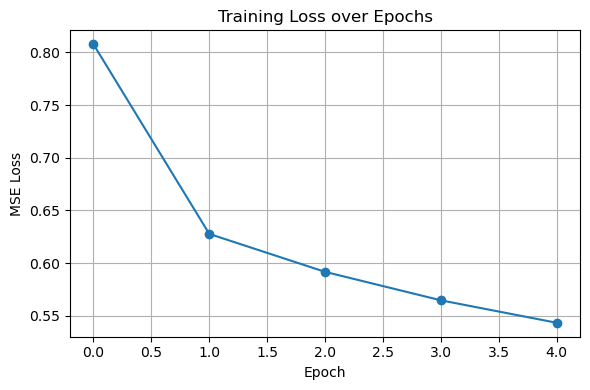

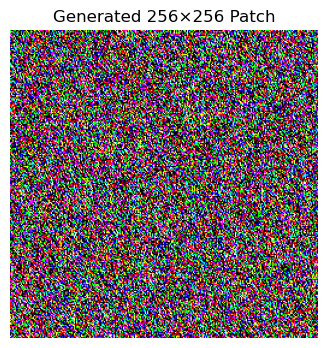

In [12]:
def generate_one_and_plot(ddpm, loss_list, C=6, patch_size=256):
    '''
    Function for plotting training loss per epoch as well as drawing
    a single sample utilizing the DDPM.sample() function.
    
    Args:
      ddpm       - your trained DDPM instance
      loss_list  - list of average losses (len == num_epochs)
      C          - number of channels your model uses (e.g. 6)
      patch_size - size of the square patch (e.g. 256)
    '''
    # Visualizing the loss curve:
    plt.figure(figsize=(6,4))
    plt.plot(loss_list, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Generating one patch from the diffusion model
    ####################################################
    #  Little help from ChatGPT on sampling from model #
    ####################################################
    ddpm.model.eval()
    with torch.no_grad():
        # sample a single patch
        sample = ddpm.sample((1, C, patch_size, patch_size)).cpu()
        
    
    # Retrieving rgb values of the sampled pictures
    # casting from [-1, 1] to [0, 1] and visualzing.
    rgb = (sample[0, :3] + 1) / 2 
    img_np = rgb.permute(1, 2, 0).clamp(0,1).numpy()
    
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title('Generated 256×256 Patch')
    plt.show()

generate_one_and_plot(ddpm, loss_list, C=6, patch_size=256)

&nbsp; 

------

&nbsp;

#### Conclusion / Final words:

In the section above we tried to train the DDPM to generate image mask pairs $(\hat{x_i},\hat{y_i})$ such that $(\hat{x_i},\hat{y_i})\in\mathbb{R}^{(3+\log_2 K)\times H\times W}$. Via doing this we could furthermore retrieve the log-encoded "binary" masks and decode them to the original masks and thereafter retrieve the labels.

After trying multiple methods (i.e. cropping and resizing techniques, img size, smaller $T$, different datasets) to achieve generated results which looked plausible, the model did not perform. I think the most plausible explanation for this is that diffusion models are models which requires an extensive amount of training outside of the specs available for me. More extensive details in `README.md` 